<a href="https://colab.research.google.com/github/rodraxphysics/Master_VIU_Data_Science/blob/main/04_Aprendizaje_No_Supervisado_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <center>  <center>
## <center> Universidad Internacional de Valencia (VIU) <center>
## <center> Trabajo Fin de Master (TFM) <center>


---


# <center> **Predicción de la magnitud de la banda prohibida (bandgap) en compuestos inorgánicos mediante técnicas de Machine Learning** <center>


---



**Titulación:** Máster en Big Data y Data Science

**Alumno:** Rodrigo Eduardo Sandoval Brito

**Director:** Jose Carlos González, PhD.



---


## <center> **Aplicacion de Aprendizaje No Supervisado para Clustering de Caracteristicas** <center>

**Importacion de dataset descargado de API de Materials Project desde archivo csv**

In [ ]:
# Imports generales
import pandas as pd
import io
from google.colab import files
import numpy as np
import time

def upload_files (index_fields=None):
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')), index_col = index_fields)

    return df

In [ ]:
df = upload_files()

Saving DATA_RAW_29222.csv to DATA_RAW_29222 (3).csv
User uploaded file "DATA_RAW_29222 (3).csv" with length 6256363 bytes


**Con el objetivo de identificar caracteristicas similares podemos buscar clusters dentro de nuestras variables. Para lo cual primero daremos una abreviacion a cada una de las caracteristicas con la finalidad de poder diferenciarlas facilmente en la visualizacion posterior**

In [ ]:
from collections import defaultdict

def get_new_name(name, abbreviations_count):
    if len(name) % 2 == 0:  # Si la longitud es par
        middle_index = len(name) // 2 - 1
    else:
        middle_index = len(name) // 2
    abbreviation = name[0] + name[middle_index] + name[-1]

    # Si es la primera vez que aparece, agregamos '0'
    # Si no, agregamos el siguiente número en la secuencia
    count = abbreviations_count[abbreviation]
    abbreviations_count[abbreviation] += 1
    return abbreviation

# Inicializamos un contador por defecto para realizar un seguimiento de las abreviaturas
abbreviations_count = defaultdict(int)

# Cambiando el nombre de las columnas
df1 = df.copy()
# Actualizamos la función get_new_name para que acepte el contador de abreviaturas
df1.columns = [get_new_name(col, abbreviations_count) for col in df1.columns]

print(df1.columns)
print(df.columns.tolist())


Index(['bdp', 'nis', 'nms', 'vle', 'dsy', 'dyc', 'c_y', 'syr', 'ssc', 'aec',
       'unm', 'epm', 'fem', 'ebl', 'ite', 'eei', 'igc', 'tnn', 'nes', 'mat'],
      dtype='object')
['band_gap', 'nsites', 'nelements', 'volume', 'density', 'density_atomic', 'crystal_symmetry', 'symmetry_number', 'sides_abc', 'angles_abc', 'uncorrected_energy_per_atom', 'energy_per_atom', 'formation_energy_per_atom', 'energy_above_hull', 'is_stable', 'efermi', 'is_magnetic', 'total_magnetization', 'num_magnetic_sites', 'molecular_weight']


**Realizamos la normalizacion de las variables**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Crear una instancia de MinMaxScaler
scaler = MinMaxScaler()

# Normalizar todas las características del dataset
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

**Buscamos el mejor punto de corte para realizar el clustering usando el metodo de la silueta**

In [ ]:
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from numpy import corrcoef, transpose, arange

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df_feat = transpose(df)

features_norm = scaler.fit_transform(df_feat)

Z = linkage(features_norm, 'ward')

max_silhouette = -1
best_cut = None

# Probar diferentes valores de corte
for t in arange(2, 20, 1):
    labels = fcluster(Z, t, criterion='maxclust')
    silhouette_avg = silhouette_score(features_norm, labels)
    if silhouette_avg > max_silhouette:
        max_silhouette = silhouette_avg
        best_cut = t

print(f"Mejor valor de corte: {best_cut} con coeficiente de silueta: {max_silhouette}")


Mejor valor de corte: 5 con coeficiente de silueta: 0.48308689816590533


**Aplicamos PCA (Principal Component Analysis) para reducir la dimensional del dataset y se utilizan solamente los dos primeros componentes principales para obtener la grafica bidimensional. Finalmente consideramos el mejor valor de corte y generamos el clustering jerarquico aglomerativo por medio del dataset transpuesto**

Index(['bdp', 'nis', 'nms', 'vle', 'dsy', 'dyc', 'c_y', 'syr', 'ssc', 'aec',
       'unm', 'epm', 'fem', 'ebl', 'ite', 'eei', 'igc', 'tnn', 'nes', 'mat'],
      dtype='object')


<ipython-input-48-3b828783f2bb>:21: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = cluster.hierarchy.linkage(matdist, method='single')


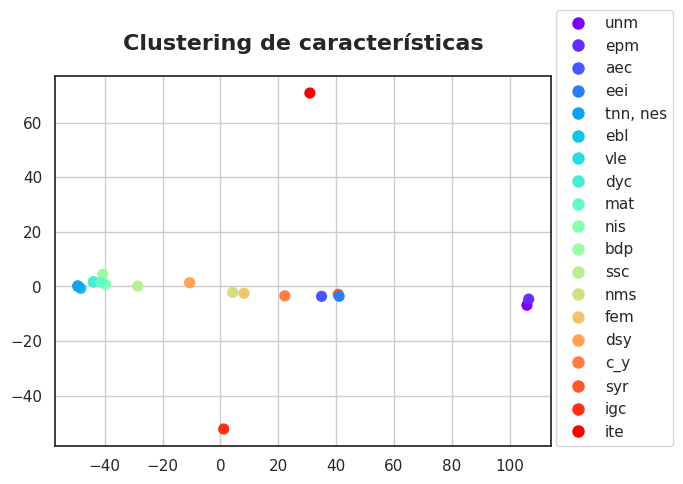

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn import preprocessing
import numpy as np
import sklearn.metrics
from scipy import cluster


df_feat = transpose(df1)
estimator = PCA (n_components = 11)
X_pca = estimator.fit_transform(features_norm)

names = df_feat.index
print(names)

dist = sklearn.metrics.DistanceMetric.get_metric('euclidean')
matdist = dist.pairwise(features_norm)

cut = best_cut
clusters = cluster.hierarchy.linkage(matdist, method='single')
labels = cluster.hierarchy.fcluster(clusters, cut, criterion='distance')

# Generando una lista de colores basada en las etiquetas únicas
unique_labels = list(set(labels))
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

# Creando un mapeo entre etiquetas y colores
label_color_map = {label: color for label, color in zip(unique_labels, colors)}

# Asignando colores a cada etiqueta
label_colors = [label_color_map[label] for label in labels]

# Plotting
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=label_colors, s=50)

# Crear una lista de etiquetas para la leyenda basadas en las etiquetas únicas
legend_labels = {}
for i, label in enumerate(labels):
    if label in legend_labels:
        legend_labels[label].append(names[i][0:4])
    else:
        legend_labels[label] = [names[i][0:4]]

legend_names = [', '.join(legend_labels[label]) for label in unique_labels]

# Añadiendo la leyenda
patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=label_color_map[label], markersize=10)
           for label in unique_labels]
plt.legend(handles=patches, labels=legend_names, loc=(1.01, 0.00))
plt.title('Clustering de características', fontsize=16, fontweight='bold', y=1.05)
plt.grid()
plt.savefig('clustering_caracteristicas.svg', format='svg', bbox_inches='tight')
plt.show()



In [ ]:
import cairosvg

In [ ]:
import cairosvg

# Convert SVG to PDF with adjustable DPI
svg_file = 'clustering_caracteristicas.svg'
pdf_file = 'clustering_caracteristicas.pdf'
dpi = 300  # Adjust DPI as needed

# Convert SVG to PDF with specified DPI
cairosvg.svg2pdf(url=svg_file, write_to=pdf_file, dpi=dpi)

print(f"Archivo PDF '{pdf_file}' creado con éxito.")

Archivo PDF 'clustering_caracteristicas.pdf' creado con éxito.
